# AG News Classification

## About the Data
### Origin
AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.

The AG's news topic classification dataset is constructed by Xiang Zhang from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

### Description
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt

from termcolor import colored

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,GlobalMaxPooling1D,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
tf.random.set_seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the dataset

In [32]:
TRAIN_FILE_PATH="./data/train.csv"
TEST_FILE_PATH='./data/test.csv'

train_data=pd.read_csv(TRAIN_FILE_PATH)
test_data=pd.read_csv(TEST_FILE_PATH)

train_data.columns = ['ClassIndex', 'Title', 'Description']
test_data.columns = ['ClassIndex', 'Title', 'Description']

X_train=train_data['Title']+" "+train_data['Description']
y_train=train_data['ClassIndex'].apply(lambda x:x-1)

X_test=test_data['Title']+ " "+test_data['Description']
y_test=test_data['ClassIndex'].apply(lambda x:x-1)

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

maxlen=X_train.map(lambda x:len(x.split())).max()
train_data.head()

labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
raw_train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(32)
raw_val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(10000).batch(32)
raw_test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(10000).batch(32)

In [33]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Title: ", text_batch.numpy()[i])
    print("Label: ", labels[label_batch.numpy()[i]])

Title:  b"HP to Sun: Get the facts straight Sun execs say they're telling it like it is: HP's Unix offering is on its last legs. HP says they're flat-out wrong."
Label:  Science-Technology News
Title:  b'Anti-terror police arrest Abu Hamza Radical Muslim cleric Abu Hamza is being questioned at Paddington Green police station in London after being arrested over alleged terrorism offences.'
Label:  World News
Title:  b'Study: Compact Disc Rocks On Digital music is ramping up, but Jupiter Research reports that the venerable CD will remain the best-selling format throughout the remainder of the decade.'
Label:  Business News


In [34]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Prepare the dataset for training

In [35]:
def custom_standardization(input_string):
    # Convert to lowercase
    input_string = tf.strings.lower(input_string)

    # Remove HTML tags
    input_string = tf.strings.regex_replace(input_string, '<br />', ' ')

    # Remove punctuation
    input_string = tf.strings.regex_replace(input_string, '[%s]' % re.escape(string.punctuation), '')

    # Remove stopwords
    stop_words = stopwords.words('english')
    stop_words_regex = r'\b(' + r'|'.join(stop_words) + r')\b\s*'
    input_string = tf.strings.regex_replace(input_string, stop_words_regex, '')

    # Lemmatize
    # lemmatizer = WordNetLemmatizer()
    # tokens = nltk.word_tokenize(input_string.numpy().decode())
    # lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    # input_string = ' '.join(lemmas)

    return input_string


In [36]:
example_sentence = "The quick brown foxes jumped over the lazy dog's back."
processed_sentence = custom_standardization(example_sentence)
print(processed_sentence)
processed_sentence

tf.Tensor(b'quick brown foxes jumped lazy dogs back', shape=(), dtype=string)


<tf.Tensor: shape=(), dtype=string, numpy=b'quick brown foxes jumped lazy dogs back'>

In [37]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [38]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [39]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [42]:
title_batch, label_batch = next(iter(raw_train_ds))
first_title, first_label = title_batch[0], label_batch[0]
print("Review", first_title)
print("Label", labels[first_label])
print("Vectorized review", vectorize_text(first_title, first_label))

Review tf.Tensor(b"Kuznetsova Stuns Davenport to Reach U.S. Open Final  NEW YORK (Reuters) - Russian Svetlana Kuznetsova stunned an  injury-hit Lindsay Davenport 1-6, 6-2, 6-4 at the U.S. Open on  Friday to reach her first grand slam final and end the  American's hopes of regaining the world number one ranking.", shape=(), dtype=string)
Label Sports News
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[5115, 9077, 3171,  578,    5,   84,  130,    3,   21,    6,  259,
        6303, 5115, 5152,    1, 4640, 3171,  637, 1344,  832,    5,   84,
          18,  578,    8,  505, 2469,  130,   87,  619,  452,    1,   10,
         317,   17, 2472,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   

In [43]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  surgery
 313 --->  agency
Vocabulary size: 10000


In [44]:
train_ds=raw_train_ds.map(vectorize_text)
val_ds=raw_val_ds.map(vectorize_text)
test_ds=raw_test_ds.map(vectorize_text)

In [45]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
embeddig_dim=16

In [49]:
model=tf.keras.Sequential([
   tf.keras.layers.Embedding(max_features+1,embeddig_dim),
   tf.keras.layers.Bidirectional(LSTM(128,return_sequences=True)),
   tf.keras.layers.Bidirectional(LSTM(64,return_sequences=True)),
   tf.keras.layers.GlobalMaxPooling1D(),
   tf.keras.layers.Dense(1024),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(512),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(256),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(128),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(64),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        148480    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1024)              132096    
                                                        

In [50]:
callbacks=[
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights2.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
]

In [51]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

history=model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=callbacks)

Epoch 1/20
3000/3000 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8681
Epoch 1: val_accuracy improved from -inf to 0.90450, saving model to weights2.h5
3000/3000 [==============================] - 268s 86ms/step - loss: 0.3913 - accuracy: 0.8681 - val_loss: 0.2937 - val_accuracy: 0.9045
Epoch 2/20
3000/3000 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9179
Epoch 2: val_accuracy did not improve from 0.90450
3000/3000 [==============================] - 255s 85ms/step - loss: 0.2624 - accuracy: 0.9179 - val_loss: 0.3063 - val_accuracy: 0.9028
Epoch 3/20
3000/3000 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9309
Epoch 3: val_accuracy did not improve from 0.90450
3000/3000 [==============================] - 255s 85ms/step - loss: 0.2165 - accuracy: 0.9309 - val_loss: 0.3671 - val_accuracy: 0.9030
Epoch 4/20
3000/3000 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9423
Epoch 4: val_accu

In [52]:
model.load_weights('weights2.h5')
model.save('model2.hdf5')

In [53]:
loss,accuracy=model.evaluate(test_ds)
print("Loss: ",loss)
print("Accuracy: ",accuracy)

238/238 [==============================] - 9s 35ms/step - loss: 0.2922 - accuracy: 0.9067
Loss:  0.29215773940086365
Accuracy:  0.9067105054855347


In [54]:
history_dict = history.history
history_dict.keys()

NameError: name 'history' is not defined

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [55]:
export_model=tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss,accuracy=export_model.evaluate(raw_test_ds)
print(accuracy)

238/238 [==============================] - 11s 36ms/step - loss: 0.8553 - accuracy: 0.9067
0.9067105054855347


In [81]:
def modelDemo(news_text):
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
  
  predictions=export_model.predict(news_text)
  
  test_preds = [labels[np.argmax(i)] for i in predictions]
  
  for news, label in zip(news_text, test_preds):
    print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [82]:
modelDemo(['New evidence of virus risks from wildlife trade'])

1/1 [==============================] - 0s 55ms/step
New evidence of virus risks from wildlife trade - Science-Technology News


In [83]:
modelDemo(['Coronavirus: Bank pumps £100bn into UK economy to aid recovery'])

1/1 [==============================] - 0s 64ms/step
Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News


In [84]:
modelDemo(['Trump\'s bid to end Obama-era immigration policy ruled unlawful'])

1/1 [==============================] - 0s 63ms/step
Trump's bid to end Obama-era immigration policy ruled unlawful - World News


In [85]:
modelDemo(['David Luiz’s future with Arsenal to be decided this week'])

1/1 [==============================] - 0s 57ms/step
David Luiz’s future with Arsenal to be decided this week - Sports News


In [86]:
modelDemo(['Indian Economic budget supports the underprivileged sections of society'])

1/1 [==============================] - 0s 74ms/step
Indian Economic budget supports the underprivileged sections of society - Business News


238/238 [==============================] - 9s 36ms/step


<Figure size 640x480 with 0 Axes>

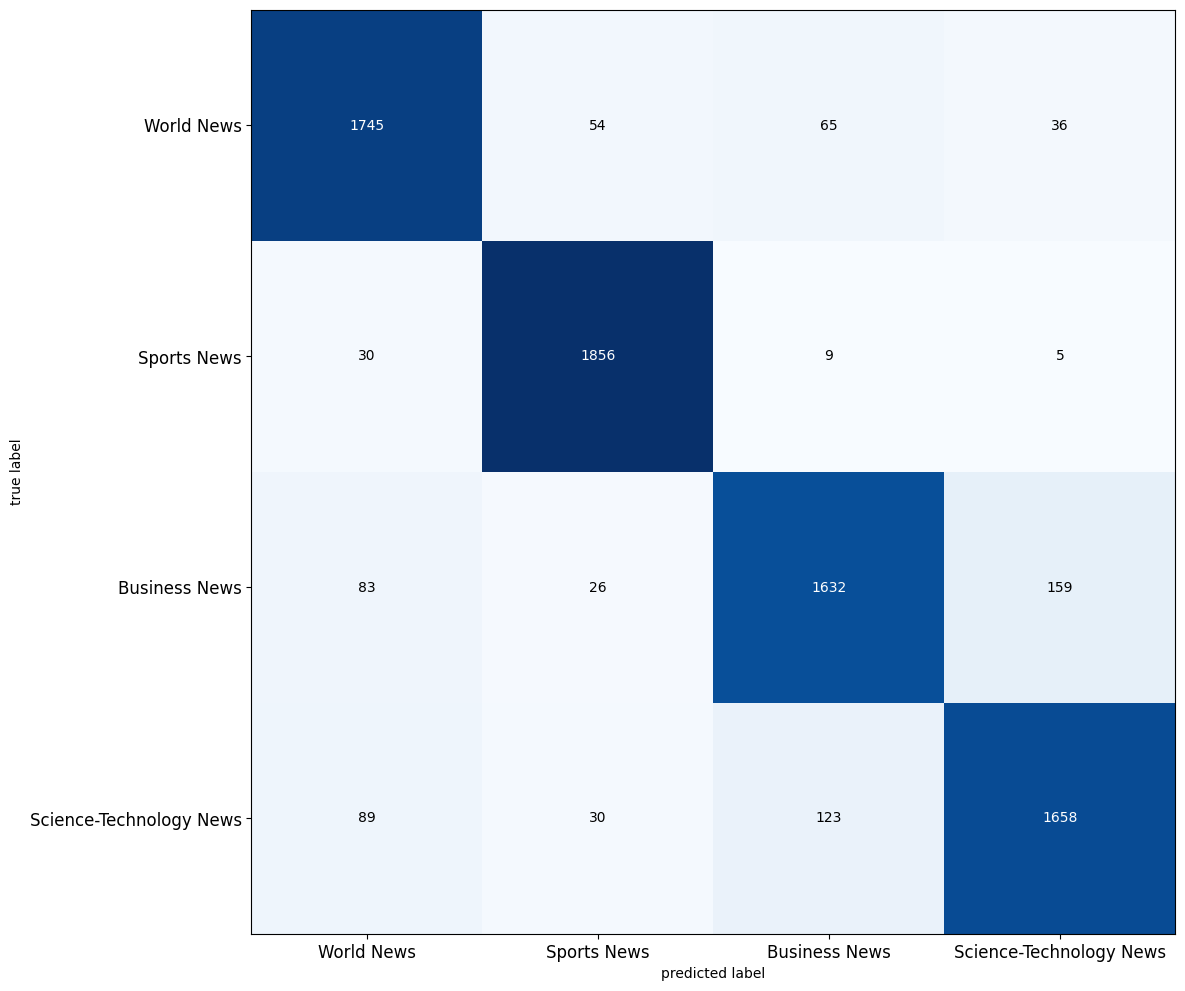

In [111]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
examples=[
    'New evidence of virus risks from wildlife trade',
    'Coronavirus: Bank pumps £100bn into UK economy to aid recovery',
    'Trump\'s bid to end Obama-era immigration policy ruled unlawful'
]
preds = [np.argmax(i) for i in export_model.predict(X_test.tolist())]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()